# lupine-single-vs-joint-performance-compare
8.1.24

Can we set up comparisons between Lupine models trained on a single CPTAC cohort vs the full Lupine model trained on all 10? I think a simple table would suffice for this. 

In [12]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# plotting templates
sns.set(context="talk", style="ticks") 
pal = sns.color_palette("tab10")

#### Configs

In [2]:
lupine_imputed_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-02-20_dream_compare/ensemble-normalized/results/lupine-ensemble-recon.csv"
lupine_test_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-02-20_dream_compare/ensemble-normalized/data/lupine-test-mat.csv"
lupine_train_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-02-20_dream_compare/ensemble-normalized/data/lupine-train-pandas.csv"

#cohort_ids=["BRCA", "CCRCC", "COAD", "GBM", "HGSC", "HNSCC", "LSCC", "LUAD", "PDAC", "UCEC"]
cohort_ids=["BRCA", "CCRCC", "COAD", "GBM", "HGSC", "HNSCC", "LSCC", "LUAD", "PDAC", "UCEC"]

#### Functions

In [3]:
def mse_func(x_pd, y_pd):
    """
    Calculate the MSE for two matricies with missing values. Each
    matrix can contain MVs, in the form of np.nans
    
    Parameters
    ----------
    x_pd : pandas.DataFrame, 
        The first matrix 
    y_pd : pandas.DataFrame, 
        The second matrix
    
    Returns
    -------
    float, the mean squared error between values present 
            across both matrices
    """
    x_mat = np.array(x_pd)
    y_mat = np.array(y_pd)
    
    x_rav = x_mat.ravel()
    y_rav = y_mat.ravel()
    missing = np.isnan(x_rav) | np.isnan(y_rav)
    mse = np.sum((x_rav[~missing] - y_rav[~missing])**2)

    return mse / np.sum(~missing)

#### Read in the full imputed quants matrices
And train/test matrices. 

In [4]:
lupine_recon_full = pd.read_csv(lupine_imputed_path, index_col=0)
lupine_test_mat = pd.read_csv(lupine_test_path, index_col=0)
lupine_train_mat = pd.read_csv(lupine_train_path, index_col=0)

lupine_recon_full.index = lupine_train_mat.index
lupine_recon_full.columns = lupine_train_mat.columns

lupine_test_mat.index = lupine_train_mat.index
lupine_test_mat.columns = lupine_train_mat.columns

print(lupine_recon_full.shape)
print(lupine_test_mat.shape)
print(lupine_train_mat.shape)

(18578, 1905)
(18578, 1905)
(18578, 1905)


#### The driver loop

In [5]:
results = []

for cohort in cohort_ids:
    # Read in the single cohort imputed quants matrix
    lupine_recon_single = pd.read_csv("results/lupine-recon-" + cohort + ".csv", index_col=0)

    # Subset the full imputed quants matrix and the test set down to the same columns
    cohort_cols = list(lupine_recon_single.columns)
    keep_prots = list(lupine_recon_single.index)

    lupine_full_cohort = lupine_recon_full[cohort_cols].loc[keep_prots]
    test_mat_cohort = lupine_test_mat[cohort_cols].loc[keep_prots]

    # print(lupine_recon_single.shape)
    # print(lupine_full_cohort.shape)
    # print(test_mat_cohort.shape)
    # print(" ")

    # Get the reconstruction errors
    lupine_full_err = mse_func(lupine_full_cohort, test_mat_cohort)
    lupine_single_err = mse_func(lupine_recon_single, test_mat_cohort)

    res = {
        "cohort" : cohort, 
        "lupine_full_error" : lupine_full_err, 
        "lupine_single_error" : lupine_single_err, 
    }
    results.append(res)
    
results = pd.DataFrame(results)

#### Wrangle

In [6]:
results = results.rename(columns={"lupine_full_error":"Full Model", 
                                  "lupine_single_error":"Single Cohort"})
# melt
results_melt = results.melt(id_vars=("cohort"))

#### Plot

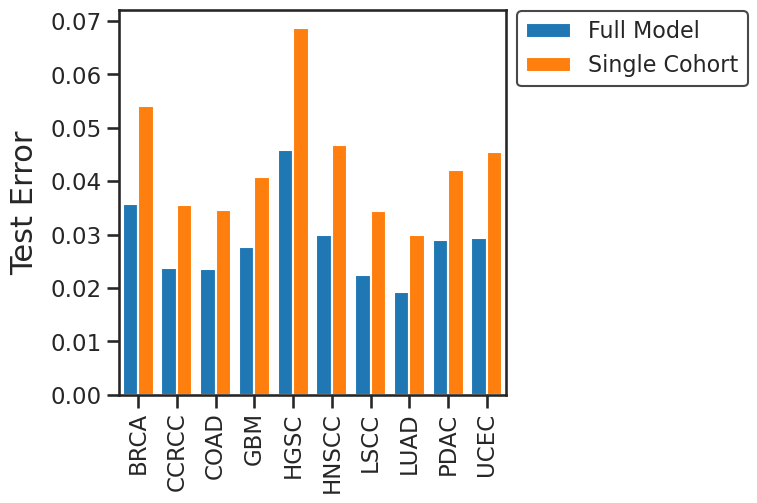

In [7]:
# plot
plt.figure(figsize=(5,5))

sns.barplot(
    data=results_melt, 
    x="cohort", 
    y="value", 
    hue="variable",
    palette="tab10", 
    saturation=1.0,
)
plt.ylabel("Test Error", labelpad=8, size=22)
plt.xlabel("", labelpad=8, size=14)
plt.legend(title="", edgecolor="k", prop={'size': 16}, bbox_to_anchor=(1.00, 1.025))
plt.xticks(rotation=90)

plt.show()
#plt.savefig("../figures/lupine-single-v-full-barplot.pdf", bbox_inches="tight")

#### Let's try a horizontal barplot

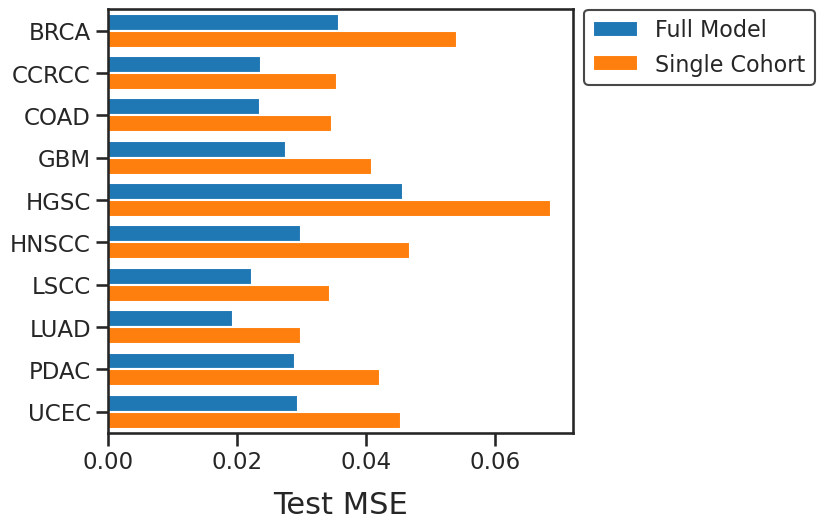

In [8]:
# plot
plt.figure(figsize=(6,5.5))

sns.barplot(
    data=results_melt, 
    x="value", 
    y="cohort", 
    hue="variable",
    palette="tab10", 
    saturation=1.0,
    orient="h",
)
plt.xlabel("Test MSE", labelpad=12, size=22)
plt.ylabel("", labelpad=8, size=14)
plt.legend(title="", edgecolor="k", prop={'size': 16}, bbox_to_anchor=(1.00, 1.025))
#plt.xticks(rotation=90)

plt.show()
#plt.savefig("../figures/lupine-single-v-full-barplot-v2.pdf", bbox_inches="tight")

#### Let's run a t-test comparing the distribution of single cohort errors vs. full model

In [13]:
full_errors = np.array(results["Full Model"])
single_errors = np.array(results["Single Cohort"])

ttest_ind(full_errors, single_errors)

TtestResult(statistic=-3.3581056587280775, pvalue=0.0035015919639362686, df=18.0)

#### And get the average percentage difference
Here were asking: by what percentage does the error decrease for an ensembled model vs a single model. 

In [29]:
full_error_mean = np.mean(full_errors)
single_error_mean = np.mean(single_errors)

print(np.around(full_error_mean, 3))
print(np.around(single_error_mean, 3))

diff = single_error_mean - full_error_mean
percentage_diff = diff / single_error_mean
print(np.around(percentage_diff, 3))

0.029
0.043
0.338
